# [Advanced] Structural optimization with symmetry

In the previous section, we learned the most primitive application of structural optimization. In this section, we will learn how to perform structural optimization while preserving the symmetry of the system. ASE has a method to handle space groups by using the constraints class `FixSymmetry`.

 - [Using the spacegroup subpackage](https://databases.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html)
 - [FixSymmetry Constraints](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-fixsymmetry-class)

This section includes some advanced contents; those who wish to hurry to the next section may skip it and read it later.

## BaTiO$_3$ optimization

Let us look at a concrete example before going into the details of [space groups](https://en.wikipedia.org/wiki/Space_group) and what we mean by "symmetry" in this section.

Here we will look at a structural optimization example of a material with a [perovskite](https://en.wikipedia.org/wiki/Perovskite_(structure)) structure BaTiO$_3$ (barium titanate).

BaTiO$_3$ is an artificial mineral used as a dielectric material for ceramic laminated capacitors because of its high relative permittivity. 
It takes a [tetragonal](https://en.wikipedia.org/wiki/Tetragonal_crystal_system) crystal system at room temperature. For more information, please refer to the following page.

 - [Barium titanate - Wikipedia](https://en.wikipedia.org/wiki/Barium_titanate)

The structure file is obtained from Materials Project.

 - https://materialsproject.org/materials/mp-5986/



Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

The following cells of BaTiO$_3$ with the tetragonal structure are $a = b \neq c$, $\alpha = \beta = \gamma =$ 90°.
($a = b = c$, $\alpha = \beta = \gamma =$ 90° case is called [cubic](https://en.wikipedia.org/wiki/Cubic_crystal_system))

In [1]:
from ase.io import read
from pfcc_extras.visualize.view import view_ngl

bto_tetra = read("../input/BaTiO3_mp-5986_computed.cif")
print(f"BaTiO3 (Tetragonal): cell = {bto_tetra.cell.cellpar()}")
view_ngl(bto_tetra, representations=[])

BaTiO3 (Tetragonal): cell = [ 4.004457  4.004457  4.200636 90.       90.       90.      ]


In [2]:
view_ngl(bto_tetra * (4, 4, 4), representations=[])

The `get_scaled_positions` method can be used to obtain the relative coordinates of each atom in the unit cell, rather than the absolute coordinates. (That is, a coordinate scale such that `[0, 0, 0]` is the origin and `[1, 1, 1]` is the point at the opposite end of the unit cell.)

If you check the `scaled_positions` in this structure, you will see that we have taken a rounded number, such as `0` or `0.5`, for the xy coordinates.

In [3]:
bto_tetra.get_scaled_positions()

array([[0.5     , 0.5     , 0.004136],
       [0.      , 0.      , 0.524313],
       [0.      , 0.5     , 0.479349],
       [0.5     , 0.      , 0.479349],
       [0.      , 0.      , 0.958854]])

Let's try to optimize the structure in the following four ways for this structure,

 - With or without `FixSymmetry` as described in this section
 - `ExpCellFilter`'s `hydrostatic_strain` argument is `True` or `False`, which was described in the previous section.

In [4]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")
calculator = ASECalculator(estimator)

Potential energy before structural optimization is

In [5]:
bto_tetra.calc = calculator
Epot = bto_tetra.get_potential_energy()
print(f"Epot before opt: {Epot} eV")

Epot before opt: -31.542818813863008 eV


In [6]:
from ase import Atoms
from ase.calculators.calculator import Calculator
from ase.constraints import ExpCellFilter
from ase.optimize import FIRE
from ase.spacegroup.symmetrize import FixSymmetry


def opt_with_symmetry(
    atoms_in: Atoms,
    calculator: Calculator,
    fix_symmetry: bool = False,
    hydrostatic_strain: bool = False,
) -> Atoms:
    atoms = atoms_in.copy()
    atoms.calc = calculator
    if fix_symmetry:
        atoms.set_constraint([FixSymmetry(atoms)])
    ecf = ExpCellFilter(atoms, hydrostatic_strain=hydrostatic_strain)
    opt = FIRE(ecf, logfile=None)
    opt.run(fmax=0.005)

    cell_diff = (atoms.cell.cellpar() / atoms_in.cell.cellpar() - 1.0) * 100
    print("Optimized Cell         :", atoms.cell.cellpar())
    print("Optimized Cell diff (%):", cell_diff)
    print("Scaled positions       :\n", atoms.get_scaled_positions())
    print(f"Epot after opt: {atoms.get_potential_energy()} eV")
    return atoms


### 1. No FixSymmetry, hydrostatic_strain=False

The crystal axes a, b, c, $\alpha, \beta, \gamma$ are all optimized independently, so you can see that the tetragonal symmetry is broken as the angles shift from 90°, although only slightly. 
The atomic coordinates are also moving freely.

In [7]:
atoms1 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=False, hydrostatic_strain=False)

Optimized Cell         : [ 3.99934991  3.99934982  4.22621746 90.00000994 90.00000837 90.00000107]
Optimized Cell diff (%): [-1.27535259e-01 -1.27537269e-01  6.08990103e-01  1.10453455e-05
  9.29705164e-06  1.19096881e-06]
Scaled positions       :
 [[4.99999920e-01 4.99999909e-01 8.53169005e-03]
 [9.99999548e-01 9.99999434e-01 5.26177450e-01]
 [1.49386373e-07 5.00000394e-01 4.77548106e-01]
 [5.00000316e-01 1.84395770e-07 4.77548103e-01]
 [6.64640304e-08 7.87764049e-08 9.56195652e-01]]
Epot after opt: -31.54351621192014 eV


### 2. Apply FixSymmetry, hydrostatic_strain=False

The tetragonal symmetry of $a = b \neq c$, $\alpha = \beta = \gamma =$ 90° is well preserved.
Also, we can see that the `scaled_positions` of the xy-coordinates also keep a number such as `0` or `0.5` (except for very small numerical errors). <br/>
This means that the relationship between sites imposed by the symmetry P 4 m m described below is preserved.
This is **the desired result for this structural optimization**.

In [8]:
atoms2 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=True, hydrostatic_strain=False)

Optimized Cell         : [ 3.9993494   3.9993494   4.22621846 90.         90.         90.        ]
Optimized Cell diff (%): [-0.12754789 -0.12754789  0.60901392  0.          0.          0.        ]
Scaled positions       :
 [[5.00000000e-01 5.00000000e-01 8.53179182e-03]
 [0.00000000e+00 0.00000000e+00 5.26177512e-01]
 [5.73971851e-42 5.00000000e-01 4.77548063e-01]
 [5.00000000e-01 1.50487754e-36 4.77548063e-01]
 [0.00000000e+00 0.00000000e+00 9.56195570e-01]]
Epot after opt: -31.543510083303296 eV


### 3. No FixSymmetry, hydrostatic_strain=True

If `hydrostatic_strain=True`, the optimization preserves the ratio of lattice lengths and angles because it applies isotropic pressure.
As you can see in the "Optimized Cell diff (%)" section, the angle is still 90°, but the a, b, and c axes are all optimized with the same ratio.
As a result, the optimization of the structure extending in the direction of the c-axis has not progressed to a minimum value. (Compared to the cases 1 and 2, the structural optimization ends with a large value of `Epot`.)

Since the atomic coordinates are free to move, the `scaled_positions` of the xy-coordinates have moved from a number such as `0` or `0.5`.

In [9]:
atoms3 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=False, hydrostatic_strain=True)

Optimized Cell         : [ 4.00530277  4.00530277  4.2015232  90.         90.         90.        ]
Optimized Cell diff (%): [0.02112064 0.02112064 0.02112064 0.         0.         0.        ]
Scaled positions       :
 [[4.99999992e-01 5.00000004e-01 7.02002071e-03]
 [9.99999942e-01 9.99999999e-01 5.24653406e-01]
 [2.01465415e-08 4.99999999e-01 4.78119738e-01]
 [5.00000038e-01 9.99999993e-01 4.78119730e-01]
 [9.01485177e-09 5.38367868e-09 9.58088105e-01]]
Epot after opt: -31.543333405214426 eV


### 4. Apply FixSymmetry, hydrostatic_strain=True

For cells, the results are similar to those in 3. 
The constraint of maintaining the lattice length ratio and lattice angle as `hydrostatic_strain=True` is more stringent than those imposed by only `FixSymmetry`.
For atomic coordinates, the `FixSymmetry` constraints keep the `scaled_positions` of the xy coordinates to `0` or `0.5`.

In [10]:
atoms4 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=True, hydrostatic_strain=True)

Optimized Cell         : [ 4.00530315  4.00530315  4.2015236  90.         90.         90.        ]
Optimized Cell diff (%): [0.02113023 0.02113023 0.02113023 0.         0.         0.        ]
Scaled positions       :
 [[5.00000000e-01 5.00000000e-01 7.01995348e-03]
 [3.36311631e-44 1.23314265e-42 5.24653379e-01]
 [0.00000000e+00 5.00000000e-01 4.78119772e-01]
 [5.00000000e-01 3.47522019e-43 4.78119772e-01]
 [0.00000000e+00 1.12103877e-44 9.58088123e-01]]
Epot after opt: -31.543335242781215 eV


### Summary

The results can be summarized as the below table.

| Case | `FixSymmetry` | `hydtrostatic_strain` | Result |
|:------|:------:|:---------:|:---------|
| 1 |  | | Cell angles, etc., change slightly because symmetry is not taken into account. |
| 2 | ✓ |  | **The desired result.** Structural optimization can be performed while maintaining the symmetry of a tetragonal crystal. <br/> The relationship between the atomic coordinate sites is also properly constrained. |
| 3 |  | ✓ | Since all a, b, and c axes are optimized in the same ratio, the structural optimization in the c-axis direction is not sufficient. <br/> Atomic coordinates also move freely. |
| 4 | ✓ | ✓ | Cell is similar to 3. The relationship of sites in atomic coordinates is subject to constraints. |

**The symmetry is a "lattice vector & equivalent site relationship" (a=b, α=β=γ=90°, etc.)**, and using `FixSymmetry` allows structural optimization to be performed while preserving this symmetry. 
More precisely, structural optimization is performed only with displacements that preserve the **space group** to which the initial structure belongs.
In the following, we will explain the definition of symmetry, i.e., the space group.

## Space group (spacegroup)

It is known that there are a total of **230 types** of patterns that can be taken by crystal structures that take regular pattern in three-dimensional space with periodic boundary conditions, which are called space groups. All crystals belong to one of the 230 space groups.

 - [Space group](https://en.wikipedia.org/wiki/Space_group)

For a list of 230 species of space groups, you can check the following sites

 - [High-Resolution Space Group Diagrams and Tables](http://img.chem.ucl.ac.uk/sgp/large/sgp.htm)


The space group of `atoms` can be specified by using `get_spacegroup` in ASE.

[Note]

The library `spglib` is used internally in the `get_spacegroup` method. <br/>
`spglib` is a library that determines the space group from unit cell and atomic coordinate information.

 - [Spglib Document](https://spglib.github.io/spglib/)
 - [github](https://github.com/spglib/spglib)
 - "`Spglib`: a software library for crystal symmetry search", Atsushi Togo and Isao Tanaka, https://arxiv.org/abs/1808.01590


Let's determine the space group for this BaTiO3 tetragonal structure.

In [11]:
from ase.spacegroup import get_spacegroup

sg = get_spacegroup(bto_tetra)
sg

Spacegroup(99, setting=1)

The following information can be obtained from the `Spacegroup` class, 

 - `no`: Number of space group
 - `symbol`: [Hermann-Mauguin](https://en.wikipedia.org/wiki/Hermann%E2%80%93Mauguin_notation) notation. (Note that [Schoenflies](https://en.wikipedia.org/wiki/Schoenflies_notation) is the another famous notation.)
 - `lattice`: Lattice type. `P` is simple lattice, `I` body centered, `F` face centered, etc.
 - `scaled_primitive_cell`: Standardized primitive cell.
 - `reciprocal_cell`: Reciprocal cell.

In [12]:
type(sg)

ase.spacegroup.spacegroup.Spacegroup

In [13]:
print("no      : ", sg.no)
print("symbol  : ", sg.symbol)
print("lattice : ", sg.lattice)
print("scaled_primitive_cell: \n", sg.scaled_primitive_cell)
print("reciprocal_cell      : \n", sg.reciprocal_cell)

no      :  99
symbol  :  P 4 m m
lattice :  P
scaled_primitive_cell: 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
reciprocal_cell      : 
 [[1 0 0]
 [0 1 0]
 [0 0 1]]


This BaTiO$_3$ structure was determined to be the 99th `P 4 m m` space group.

 - P4mm: http://img.chem.ucl.ac.uk/sgp/large/099az1.htm

The space group specifies the possible symmetry operations (such as translation, rotation, mirror image flips, and glide) that do not change its crystal structure. <br/>
The details of the theory of space group, including how to read symbols, are out of the scope of this tutorial. Please refer to the references at the end of this document for those who wish to learn more.

In this tutorial, we will try to give an intuitive explanation of what space groups are by visualizing them.
`P 4 m m` is a space group with 4-fold rotational symmetry (invariant to transformations that rotate it 90 degrees along the z-axis) and mirror-reversal symmetry with respect to the xz-plane and yz-plane.

For a given atomic configuration, the "equivalent sites" imposed by this symmetry can be calculated with the method `equivalent_lattice_points`.
Let us calculate and display the equivalent sites for a point (`[0.3, 0.1, 0.6]`) as follows.

In [14]:
sites, kinds = sg.equivalent_sites([[0.3, 0.1, 0.6]])
print("sites", sites)

p4mm_atoms = Atoms(symbols="C8", scaled_positions=sites, cell=[5, 5, 5], pbc=True)
view_ngl(p4mm_atoms)

sites [[0.3 0.1 0.6]
 [0.7 0.9 0.6]
 [0.9 0.3 0.6]
 [0.1 0.7 0.6]
 [0.3 0.9 0.6]
 [0.7 0.1 0.6]
 [0.9 0.7 0.6]
 [0.1 0.3 0.6]]


Thus, we can see that a total of 8 points are listed as equivalent sites, including points obtained by rotating 90 degrees along the z-axis from `[0.3, 0.1, 0.6]` and by performing a mirror image flip from those points to the xz-plane/yz-plane.

Let us look again at the structure of BaTiO$_3$.

In [15]:
view_ngl(bto_tetra)

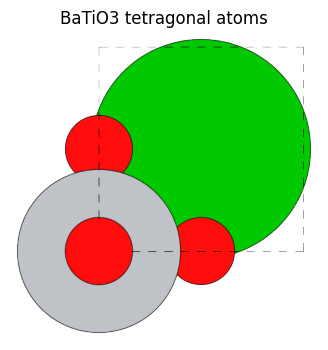

In [16]:
from pfcc_extras.visualize.ase import view_ase_atoms

view_ase_atoms(bto_tetra, figsize=(4, 4), title="BaTiO3 tetragonal atoms", scale=100, rotation="0x,0y,0z")

As for the BaTiO$_3$ structure in this case:

For Ba at `index=0`, Ti at `index=1`, and O at `index=4`, the only equivalent site is themselves since they move to the same location after rotation or mirror image inversion, except for a unit cell shift.
The O structures at `index 2` and `3` are found to be equivalent sites to each other due to 4-fold rotational symmetry.

In [17]:
spos = bto_tetra.get_scaled_positions()
symbols = bto_tetra.symbols

for i in range(len(spos)):
    print(i, symbols[i], sg.equivalent_sites(spos[i]))    

0 Ba (array([[0.5     , 0.5     , 0.004136]]), [0])
1 Ti (array([[0.      , 0.      , 0.524313]]), [0])
2 O (array([[0.      , 0.5     , 0.479349],
       [0.5     , 0.      , 0.479349]]), [0, 0])
3 O (array([[0.5     , 0.      , 0.479349],
       [0.      , 0.5     , 0.479349]]), [0, 0])
4 O (array([[0.      , 0.      , 0.958854]]), [0])


Finally, we will try to determine the space group for each of the four structures after structural optimization in this tutorial.

The `symprec` argument of the `get_spacegroup` method allows you to set a tolerance for the shift of each atom's coordinates when making the symmetry determination.
In this case, the default value of `symprec=1e-5` resulted in `P 4 m m`, so we set a strictly smaller value to determine the space group.

In [18]:
symprec = 1e-10

print("atoms1: ", get_spacegroup(atoms1, symprec=symprec).symbol)
print("atoms2: ", get_spacegroup(atoms2, symprec=symprec).symbol)
print("atoms3: ", get_spacegroup(atoms3, symprec=symprec).symbol)
print("atoms4: ", get_spacegroup(atoms4, symprec=symprec).symbol)

atoms1:  P 1
atoms2:  P 4 m m
atoms3:  P 1
atoms4:  P 4 m m


Thus, `atoms2` and `atoms4` with `FixSymmetry` are `P 4 m m` **preserving the space group**, but
`atoms1` and `atoms3` have broken the space group and are now at `P 1`, which is the least symmetric.

 - 1  P1  : http://img.chem.ucl.ac.uk/sgp/large/001az1.htm
 - 99 P4mm: http://img.chem.ucl.ac.uk/sgp/large/099az1.htm

## Bravais lattice

Now that we have explained the space group, we will explain a related concept, the Bravais lattice.

 - [Crystal structure - Wikipedia](https://en.wikipedia.org/wiki/Crystal_structure)
 - [Bravais lattice - Wikipedia](https://en.wikipedia.org/wiki/Bravais_lattice)
 - https://wiki.fysik.dtu.dk/ase/ase/lattice.html
 
The space group is a symmetry that depends on both the cell and atomic configuration of the atoms, whereas the Bravais lattice is determined from the cells only.
Bravais lattices are known to be one of the following **14 types**.
These 14 types are also illustrated in the Wikipedia link above.

In [19]:
from ase.lattice import CUB, FCC, BCC, TET, BCT, HEX, RHL, ORC, ORCF, ORCI, ORCC, MCL, MCLC, TRI

print(" 1. CUB:", CUB.longname, ",", CUB.crystal_family)
print(" 2. FCC:", FCC.longname, ",", FCC.crystal_family)
print(" 3. BCC:", BCC.longname, ",", BCC.crystal_family)
print(" 4. TET:", TET.longname, ",", TET.crystal_family)
print(" 5. BCT:", BCT.longname, ",", BCT.crystal_family)
print(" 6. HEX:", HEX.longname, ",", HEX.crystal_family)
print(" 7. RHL:", RHL.longname, ",", RHL.crystal_family)
print(" 8. ORC:", ORC.longname, ",", ORC.crystal_family)
print(" 9. ORCF:", ORCF.longname, ",", ORCF.crystal_family)
print("10. ORCI:", ORCI.longname, ",", ORCI.crystal_family)
print("11. ORCC:", ORCC.longname, ",", ORCC.crystal_family)
print("12. MCL :", MCL.longname, ",", MCL.crystal_family)
print("13. MCLC:", MCLC.longname, ",", MCLC.crystal_family)
print("14. TRI :", TRI.longname, ",", TRI.crystal_family)

 1. CUB: primitive cubic , cubic
 2. FCC: face-centred cubic , cubic
 3. BCC: body-centred cubic , cubic
 4. TET: primitive tetragonal , tetragonal
 5. BCT: body-centred tetragonal , tetragonal
 6. HEX: primitive hexagonal , hexagonal
 7. RHL: primitive rhombohedral , hexagonal
 8. ORC: primitive orthorhombic , orthorhombic
 9. ORCF: face-centred orthorhombic , orthorhombic
10. ORCI: body-centred orthorhombic , orthorhombic
11. ORCC: base-centred orthorhombic , orthorhombic
12. MCL : primitive monoclinic , monoclinic
13. MCLC: base-centred monoclinic , monoclinic
14. TRI : primitive triclinic , triclinic


In ASE, the `get_bravais_lattice` method can be used to determine the bravais lattice.

In [20]:
bto_tetra.cell.get_bravais_lattice()

TET(a=4.0044570000000003773, c=4.2006360000000002586)

For the tetragonal BaTiO3 structure, TET was obtained as expected.

It is important to note that the cell must be a primitive cell.

When you create a Fe BCC structure and use `get_bravais_lattice`, if you specify a unit cell, it returns BCC as expected, but if we made a structure with cubic unit cell with `cubic=True`, CUB is returned.

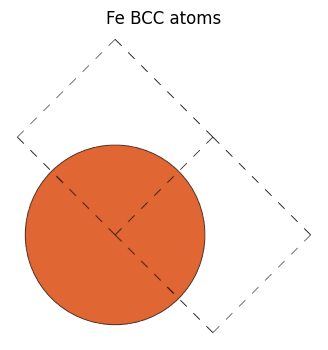

In [21]:
from ase.build import bulk
from pfcc_extras.visualize.ase import view_ase_atoms

fe_bcc = bulk("Fe")
view_ase_atoms(fe_bcc, figsize=(4, 4), title="Fe BCC atoms", scale=100, rotation="0x,0y,0z")

In [22]:
# view_ngl(fe_bcc)

In [23]:
print("fe_bcc Bravais lattice:", fe_bcc.cell.get_bravais_lattice())
print("fe_bcc cell           :", fe_bcc.cell)

fe_bcc Bravais lattice: BCC(a=2.87)
fe_bcc cell           : Cell([[-1.435, 1.435, 1.435], [1.435, -1.435, 1.435], [1.435, 1.435, -1.435]])


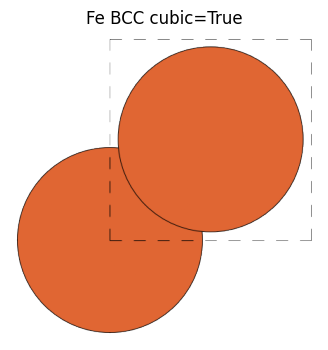

In [24]:
fe_cubic = bulk("Fe", cubic=True)
view_ase_atoms(fe_cubic, figsize=(4, 4), title="Fe BCC cubic=True", scale=100, rotation="0x,0y,0z")

In [25]:
# view_ngl(fe_cubic)

In [26]:
print("fe_cubic Bravais lattice:", fe_cubic.cell.get_bravais_lattice())
print("fe_cubic cell           :", fe_cubic.cell)

fe_cubic Bravais lattice: CUB(a=2.87)
fe_cubic cell           : Cell([2.87, 2.87, 2.87])


## Reference

If you would like to learn more about space groups, the following reference will be helpful.

 - "Space Groups for Solid State Scientists", Michael Glazer and Gerald Burns.